[ 생각해보기 ]

상품명 : 일시불, 무이자로 나누기, 무), (무), (일) 
--

=> 일시불, 무이자의 전체 합, 평균은 편성 횟수 및 시기가 비슷하고, 제품의 가격 또한 같다

=> 제품을 사야겠다고 생각한 뒤 가장 최종적으로 결정하는 요소임

=> 무이자라고, 일시불이라고 제품을 사는게 아니다 !!!!!

=> 같은 상품에 대해 일시불, 무이자가 영향을 미치는지는 모델링을 해봐야 알 것 같다

브랜드(마더코드) 활용 
-- 
=> 마더코드가 현재 숫자로 이루어져있지만, 브랜드파워가 있음

=> 마더코드별 취급액 확인 후, 취급액의 범위에 따라 / 판매단가 범위에 따라 범주화해보자  


1+1 , 세트 / 6인용, 10인용
--

=> 해보고 싶은데 종류가 너무 많아............. 제일 마지막에 해보장

초특가, 파격가, 세일 등등
--

=> 같은 상품인데 상품명에 '단어'가 붙음에 따라 취급액에 변화가 있는지 확인 필요

=> 판매 단가의 변동이 있을 수도 있기 때문에 이것도 같이 확인해주자 


국내산 // 햇
--

=> 좋은거 먹자!는 마음! 

=> 같은 상품코드에 대해 국내산 / 아닌 것 의 비교

비교하고자 하는 게 같은 품목에 대한 국내산 or not 인지, 같은 제품에 대해 상품명 국내산 표기 or not인지 명확히 하기( 확인해야함 )


여행 + 투어 
--

=> 작년은 많았을텐데 올해는 없을 것으로 예상...............

=> 데이터를 아예 빼는게 좋지 않을까?????? 라는 생각이 든다아

=> 상품명에 회사 + 제품이 있는데 회사(참좋은여행)에서 호텔 을 판매할 수도 있지 않나????( 확인해야함 )


무료 / 체험
--

=> 이런 키워드가 어떤 영향이 있을지???????????

# 데이터 정제

In [11]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import numpy as np
from datetime import datetime
import time

# 한글 폰트 설정

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)
plt.rc('font', size=20)

# 지수 표현 안보기


In [12]:
# 데이터 로드
data = pd.read_csv('data/train.csv', encoding='cp949', header=0, parse_dates=["방송일시"])

# 상품군 = 무형 제거 

data.drop(data[data['상품군']=='무형'].index, inplace=True)
data.reset_index(inplace=True)


# 판매단가, 취급액 쉼표 제거 , int 변환

data['판매단가'] = data['판매단가'].str.replace(',','').astype(int)
data[' 취급액 '] = data[' 취급액 '].str.replace(',','').astype(int)
data['노출(분)'] = data['노출(분)'].astype(int)


# 방송일시 column 분리 ( , 일, 시, 분, 요일 )

data['방송일시'] = pd.to_datetime(data['방송일시'], format='%Y-%m-%d %H:%M:%S', errors='raise')

data['month'] = data['방송일시'].dt.month
data['day'] = data['방송일시'].dt.day
data['hour'] = data['방송일시'].dt.hour
data['minute'] = data['방송일시'].dt.minute
data['요일'] = data['방송일시'].dt.weekday

# 06 ~ 익일 02 가 한 cycle임을 고려하여 0, 1, 2 에 +24를 해주자

# def plus_24(x) :
#     if x in [0, 1, 2] :
#         return x + 24
#     else :
#         return x
    
# data['hour'] = list(map(plus_24, data['hour']))
overnight_index_list = df.loc[(data["hour"] >=0) & (data["hour"] < 3)].index

overnight_index_list
data.loc[overnight_index_list, "hour"] += 24
data.loc[overnight_index_list, "day"] -= 1
data.loc[overnight_index_list, "요일"] -= 1
data.loc[data["요일"] == -1, "요일"] = 6

# 엑셀에서 수정필요
# day = 0 인 곳, 그 전달의 마지막 날짜로 변경해주기
# month, day 변경 필요
# 2월은 28일까지
# 연말 12 / 31

In [13]:
# use data
df = data.loc[:,['month','day','hour','minute','요일','상품군','마더코드','상품코드','상품명','노출(분)','판매단가',' 취급액 ']]


# 무이자, 일시불을 나타내는 단어 통일
def replace_word(x) :
    if '무)'in x :
        return x.replace('무)', '무이자')
    elif '일)' in x :
        return x.replace('일)', '일시불')
    else :
        return x
    
df['상품명'] = list(map(replace_word, df['상품명'])) 

# 일시불 = 1, 무이자 = 2 로 하는 column 생성
new = []
for i in range(len(df['상품명'])) :
    if '일시불' in df['상품명'][i] :
        df['상품명'][i] = df['상품명'][i].replace('일시불','')
        new.append(1)
    elif '무이자' in df['상품명'][i] :
        df['상품명'][i] = df['상품명'][i].replace('무이자','')
        new.append(2)
    else :
        new.append(0)

df['pay_type'] = pd.DataFrame(new)

# 이외에 '특정단어'를 포함한 상품명에 대해 분석하고 싶은 경우
def make_new_col(word) :
    new = []
    for i in range(len(df['상품명'])) :
        if word in df['상품명'][i] :
            df['상품명'][i] = df['상품명'][i].replace(word,'')
            new.append(1)
        else :
            df['상품명'][i] = df['상품명'][i].replace(word,'')
            new.append(0)
    df[word] = pd.DataFrame(new)
    return df

#make_new_col('햇')
#make_new_col('초특가')
#make_new_col('국내산')
#make_new_col('무료')

# 엑셀로 저장, 월일 변경하는거 잊지말기 !!!
# df.to_csv('./analysis/tmp.csv', index=False, encoding='cp949')

C:\python\envs\cpu_env\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\python\envs\cpu_env\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 연습 ( 햇 )


* 특정 키워드를 추출해서 어떤걸 확인해보지 ???

- 노출시간에 따라 취급액을 확인했더니 11분일 때 취급액이 매우크다.

-> 확인 결과 '햇' 단어 확인
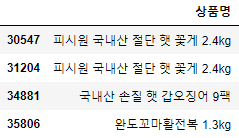

->  '햇' 단어가 든 상품 / 아닌 것 비교해보자

---
---
---
---
---
노출시간을 먼저 합해줘야하나 ????? pending !!!!!!!!

In [10]:
idx = []
for i in range(len(df['상품명'])) : 
    if '햇' in df['상품명'][i] :
        idx.append(i)

# '햇'글자 포함(185row)
print(df.iloc[idx].mean())
# '햇'글자 제외
print(df.drop(idx).mean())


## 주의 : '햇' 단어에 햇반?과 같은 단어 있는지 확인 (test set)
## 결과 : 판매단가가 비슷, 노출시간은 '햇' 단어 제외가 더 많음, 취급액은 '햇'포함이 훨씬 높음
## + ) 당연한 것 같기도하고 ???????????????????
## 아닌가????????????

month       1.044324e+01
day         1.736216e+01
hour        1.690811e+01
minute      1.967568e+01
요일          3.383784e+00
마더코드        1.003487e+05
상품코드        2.013257e+05
노출(분)       1.962162e+01
판매단가        4.990000e+04
 취급액        6.551279e+07
pay_type    0.000000e+00
dtype: float64
month       6.443461e+00
day         1.527676e+01
hour        1.630594e+01
minute      2.007287e+01
요일          3.015973e+00
마더코드        1.003897e+05
상품코드        2.012113e+05
노출(분)       2.038546e+01
판매단가        4.700806e+05
 취급액        2.165595e+07
pay_type    5.793422e-01
dtype: float64


## 2.

하고싶응거..........

month, day가 같은데 상품코드가 같다면 ? ( 여기에 일시불 , 무이자 / 몇인용 그런거 다 포함 된거임 )

for 문 돌면서 똑같은거 나올 때 까지 idx append


In [15]:
df

,month,day,hour,minute,요일,상품군,마더코드,상품코드,상품명,노출(분),판매단가,취급액,pay_type
0,1,1,6,0,1,의류,100346,201072,테이트 남성 셀린니트3종,20,39900,2099000,0
1,1,1,6,0,1,의류,100346,201079,테이트 여성 셀린니트3종,20,39900,4371000,0
2,1,1,6,20,1,의류,100346,201072,테이트 남성 셀린니트3종,20,39900,3262000,0
3,1,1,6,20,1,의류,100346,201079,테이트 여성 셀린니트3종,20,39900,6955000,0
4,1,1,6,40,1,의류,100346,201072,테이트 남성 셀린니트3종,20,39900,6672000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37367,12,31,23,40,1,주방,100448,201391,쿠첸압력밥솥 6인용,20,148000,10157000,1
37368,1,0,24,0,1,주방,100448,201383,쿠첸압력밥솥 10인용,20,178000,50929000,2
37369,1,0,24,0,1,주방,100448,201390,쿠첸압력밥솥 10인용,20,168000,104392000,1
37370,1,0,24,0,1,주방,100448,201384,쿠첸압력밥솥 6인용,20,158000,13765000,2
